In [1]:
import onnx

import torch
import torch.onnx

In [4]:
import io
import contextlib

from config import get_config
from Learner import face_learner
from data.data_pipe import get_val_data, get_val_dataset

In [5]:
with contextlib.redirect_stdout(io.StringIO()):
    conf = get_config(training=True)
    conf.device = 'cpu'
    conf.use_mobilfacenet = True

    checkpoint = '/workspace/InsightFace_Pytorch/work_space/save/model_2022-08-05-22-09_accuracy:0.939209726443769_step:759_final.pth'
    checkpoint = torch.load(checkpoint, map_location='cpu')

    learner = face_learner(conf, inference=False)
    learner.load_state_dict(checkpoint)

In [6]:
# 모델에 대한 입력값
learner.eval()
batch_size = 1
x = torch.randn(batch_size, 3, 112, 112, requires_grad=True)
torch_out = learner(x)

In [7]:
torch_out.dtype

torch.float32

In [8]:
# 모델 변환
with contextlib.redirect_stdout(io.StringIO()):
    torch.onnx.export(learner, # 실행될 모델
                      x, # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                      "model_2022-08-05-22-09_accuracy:0.939209726443769_step:759_final.onnx",# 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                      verbose=True, 
                      input_names=['input'], 
                      output_names=['output'])

In [13]:
with contextlib.redirect_stdout(io.StringIO()):
    # Preprocessing: load the model to be converted.
    model_path = 'model_2022-08-05-22-09_accuracy:0.939209726443769_step:759_final.onnx'
    original_model = onnx.load(model_path)
print('The model before conversion:\\n{}'.format(original_model))

with contextlib.redirect_stdout(io.StringIO()):
    # Check the model
    onnx.checker.check_model(original_model)
print('The model is checked!')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
from onnx import version_converter, helper
# Apply the version conversion on the original model
converted_model = version_converter.convert_version(original_model, 7)
print('The model after conversion:\\n{}'.format(converted_model))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
onnx.save(converted_model, 'model_2022-08-05-22-09_accuracy:0.939209726443769_step:759_final_v7.onnx')

In [17]:
import onnxruntime as ort

In [21]:
import numpy as np
with contextlib.redirect_stdout(io.StringIO()):
    
    ort_session = ort.InferenceSession("model_2022-08-05-22-09_accuracy:0.939209726443769_step:759_final_v7.onnx")
    
    dataset, _ = get_val_dataset('data/facebank/test')
    all_y_true, all_y_pred = [], []
    
    for image, label in dataset:
        image = image.cpu().numpy().astype(np.float32)
        
        outputs = ort_session.run(
            ['output'],
            {"input": image[np.newaxis, ...]},
        )
        _, predicted = torch.max(torch.from_numpy(np.array(outputs[0])), 1)
        all_y_true, all_y_pred = np.append(all_y_true, label), np.append(all_y_pred, predicted.cpu().numpy())

2022-08-10 20:34:22.958649198 [W:onnxruntime:Default, graph.cc:2204 CleanUnusedInitializers] model.conv1.bn.num_batches_tracked exists in this graph's initializers but it is not used by any node
2022-08-10 20:34:22.958689416 [W:onnxruntime:Default, graph.cc:2204 CleanUnusedInitializers] model.conv_3.model.2.project.bn.num_batches_tracked exists in this graph's initializers but it is not used by any node
2022-08-10 20:34:22.958698069 [W:onnxruntime:Default, graph.cc:2204 CleanUnusedInitializers] model.conv_4.model.1.conv_dw.bn.num_batches_tracked exists in this graph's initializers but it is not used by any node
2022-08-10 20:34:22.958705281 [W:onnxruntime:Default, graph.cc:2204 CleanUnusedInitializers] model.conv_4.model.0.project.bn.num_batches_tracked exists in this graph's initializers but it is not used by any node
2022-08-10 20:34:22.958712564 [W:onnxruntime:Default, graph.cc:2204 CleanUnusedInitializers] model.conv_34.conv_dw.bn.num_batches_tracked exists in this graph's initiali

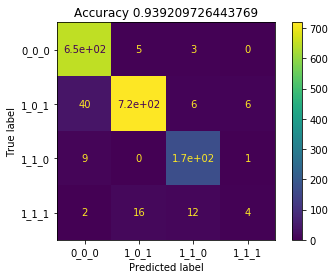

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

cm = confusion_matrix(all_y_true, all_y_pred)
accuracy = accuracy_score(all_y_true, all_y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['0_0_0', '1_0_1', '1_1_0', '1_1_1']).plot()
plt.title(f'Accuracy {accuracy}')
plt.show()